# Lecture 22 Predictive Model Tuning


A large part of setting up machine learning models involves repetitive trials, and trial and error tests. We have several tools that can largely automate this trial process, saving us the trouble of making repetitve loops and managing large lists of test values and results. 

One of the things that we can use this for is to find good values for what we call Hyperparamaters - or the values that steer the model creation process. 

## 22.0 Setup

In [2]:
import numpy as np
import pandas as pd

import scipy.stats as ss
import math
import random

import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline 

In [27]:
from sklearn import (datasets,
                     metrics,
                     compose,
                     impute,
                     preprocessing,
                     pipeline,
                     model_selection as skms,
                     linear_model,
                     ensemble,
                     tree,
                     neighbors)

In [4]:
## Ignore deprecation and future, and user warnings.
import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

## 22.1 What is a Hyperparameter?

A hyperparameter is a futuristic term for a simple concept - hyperparameters are the settings that dictate how a machine learning algorithm will behave during training - the "rules" under which a model will be trained. Hyperparameters are generally the arguments that we provide when creating a model in code. 

Hyperparameters can be contrasted with regular parameters:
<ul>
<li> Hyperparameters are defined <b>outside</b> of the training process and control how that process works. To adjust a hyperparameter we need to do it by "hand" (more on this later), the algorithm can't figure out the optimal setting during training. 
<li> Parameters exist <b>inside</b> the training process, and these are adjusted by the algorithm during training. The parameters are things like the slopes and intercept that are generated by a linear/logsitic regression. 
</ul>

This means that to get an accurate model we generally have two processes of determining the "best" model, one that we handle manually (hyperparameters), and one that is done within the training process. We generally don't know what a good hyperparameter setting is ahead of time (we sometimes have an idea), so the only way to actually find the best model is to try with different hyperparameter settings, make several models, calculate the accuracy of each, and pick the best model. So running multiple trials with slightly different scenarios is a common part of the machine learning process.

In [10]:
# Load the Breast Cancer dataset
breast_cancer_data = datasets.load_breast_cancer()

# Create a DataFrame from the dataset
breast_cancer_df = pd.DataFrame(data=breast_cancer_data.data, columns=breast_cancer_data.feature_names)
breast_cancer_df['target'] = breast_cancer_data.target

breast_cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


<h4>Generate Decision Tree Model</h4>

Create a model with the above data and display the resulting decision tree. 

The random state thing is to make it generate the same results each run, that's not really needed in general, but trees can be very different on each training run, so this will make things a little more stable as we explore. 

6
0.958041958041958


[Text(0.6201923076923077, 0.9285714285714286, 'X[27] <= 0.142\ngini = 0.467\nsamples = 426\nvalue = [158, 268]'),
 Text(0.3942307692307692, 0.7857142857142857, 'X[23] <= 929.8\ngini = 0.165\nsamples = 287\nvalue = [26, 261]'),
 Text(0.21153846153846154, 0.6428571428571429, 'X[22] <= 101.95\ngini = 0.072\nsamples = 267\nvalue = [10, 257]'),
 Text(0.11538461538461539, 0.5, 'X[10] <= 1.048\ngini = 0.017\nsamples = 230\nvalue = [2, 228]'),
 Text(0.07692307692307693, 0.35714285714285715, 'X[13] <= 48.975\ngini = 0.009\nsamples = 229\nvalue = [1, 228]'),
 Text(0.038461538461538464, 0.21428571428571427, 'gini = 0.0\nsamples = 226\nvalue = [0, 226]'),
 Text(0.11538461538461539, 0.21428571428571427, 'X[5] <= 0.063\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.07692307692307693, 0.07142857142857142, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.15384615384615385, 0.07142857142857142, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.15384615384615385, 0.35714285714285715, 'gini =

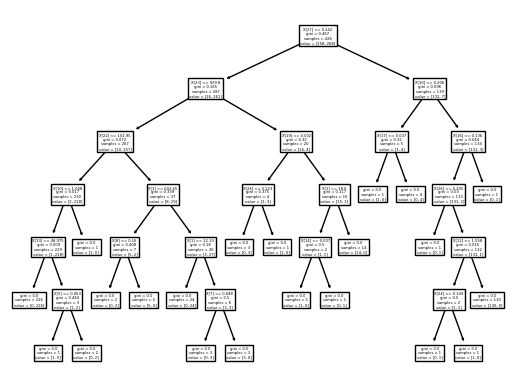

In [16]:
df2 = pd.get_dummies(breast_cancer_df, drop_first=True)
y = np.array(df2["target"]).reshape(-1,1)
x = np.array(df2.drop(columns={"target"}))

x_train, x_test, y_train, y_test = skms.train_test_split(x, y)

clf = tree.DecisionTreeClassifier(random_state=10)
clf = clf.fit(x_train, y_train)
print(clf.get_depth())
print(clf.score(x_test, y_test))
tree.plot_tree(clf)

### Model Tuning - Changing the Model's Learning

#### What About Limiting Depth?

Now, if we wanted to run a trial with different max depths we could just change the number in the argument and repeat. If we wanted to get a little more sophisticated, we could write a loop to try a few and see the results. However, what if we want to change several of these hyperparamaters in different trials? Writting a nested loop for each different value we're changing could become pretty cumbersome, and the more clunky it is, the more likely we are to make a mistake. 

### Hyperparamaters and GridSearchCV

Luckily, this is a common task, so there are prebuilt ways to do it efficiently. What we are doing here is Hyperparamater Tuning, and the tool we'll use is called GridSearchCV, from sklearn. GridSearchCV is effectively a shortcut to nested loops for each hyperparamater - we provide a list of which variables we'd like to change, and which values we'd like the system to try, and it does the messy work of running a bunch of trials behind the scenes for us. Much easier to use, and less prone to making a mistake. 

For this trial, we'll change the max depth and also the min_samples_split value - this hyperparamater sets how many values must be in one node before it can be split into 2. The default is 2, and this may sometimes lead to overfitting - we can try a few other options. 

#### Using Grid Search

A grid search object fits into the other pipeline objects that we've used before, in a similar way. We specify:
<ul>
<li> Which algorithm to train/fit. 
<li> Which hyperparameters to try, and which values to test. 
<li> The number of cross validation trials (more on this in a moment)
</ul>

The grid search object will automatically run the entire process that we are used to in training a model - train/test split of the data, train model, check accuracy - but it will do it for each combination of hyperparameter options that we defined in the lists.

For the example below, we specified the maximum depth and the minimum number of items before a node can be split, these are two hyperparameters that control how the model's training process runs. The grid search will do the entire process for each possible combination of those values we listed, check the accuracy of the resulting model, and eventually give us the best one. 

The grid search process is really useful, we don't need to manually guess and test a bunch of different combination of hyperparameters, we can set the potential options and just let it run. In theory, if we were to set every possible option for every possible hyperparameter we'd have an automated way of finding the absoulte most accurate set of HP to use, however that would be pretty impractical in terms of time to run. We want to narrow down the possibilities a bit using both our judegement and the results of the model in ititial trials and exploration. For example, in this one we can see that the trail run has many layers and many nodes with very small numbers that are split, so that's a good indication we may want to limit those in our grid search. The exact options and what we 'should' try will differ depending on the algorithm we are using. SK Learn also has some varaiations on the grid search that aim to make the process faster, they implement things like random trials of hyperparameter values or slicing down the potential HP values to try. We won't spend much time looking at these, the concept is the same as the original grid search just with a bit of variance in how the list of HP values to try; you can test one out pretty easily once comfortable with the grid search. 

In [19]:
from sklearn.model_selection import GridSearchCV

#Create a dictionary of HP names and lists of potential values. 
#The grid search will try all of these options. 
tree_para = {'min_samples_split':[2,3,4,5,6,7],
            'max_depth':[3,4,5,6,7,8]
            }

clf = GridSearchCV(estimator=tree.DecisionTreeClassifier(), param_grid=tree_para, cv=10) #See below for the CV argument
clf.fit(x_train, y_train)
clf.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_split=3)

Voila!!

There is not much of a downside to trying every possible combination of every HP, especially for us with our small datasets. The main drawback is that this can become REALLY computationally expensive with lots of options and large amounts of data. The growth in calculation time grows exponentially the more options are added, so for real world datasets just "trying everything" is probably prohibitably slow. 

There are some ways to cut down on useless trials, some are listed in the sklearn documentation. We'll look at making this better more in the future in a little more depth. For large datasets, taking a sample to experiment on is probably a prudent move. 

## Cross Validation

The CV argument above stands for cross validation - another way to prevent overfitting and increase overall accuracy. Cross validation is basically a supercharged test-train split. 

The standard test-train split divides the data 70/30ish, calculating the accuracy using that reserved 30ish percent. 

Cross validation makes K splits in the data, and repeats this test-train calculation K times. Each time a different subset is the test set, and the rest of the data is the training set. The overall score is the average of all those K trials. There are other methods in addition to K-fold, such as Leave-One-Out, which leaves only 1 example in the test set, and others that stratify to deal with target imbalance. Using these is pretty similar, we'll touch on them later. 

Cross validation is a very common step in machine learning. It reduces variance in the results as any random difference in the test-train split is negated by all the other samples. In general, cross validation will give more reliable results due to that reduction in variance - that effect being greater when there are outliers (think if one outlier is tested in a linear regression, that amount of error may be substantial). In testing the accuracy of models previously we'd occasionally see wild variations in the results due to randomness in how the data ended up being split, this cross validation process (largely) neutralizes that issue. 

We will use a separate cross validation in the future, it is also in sklearn and is pretty straightforward. We commonly use it as part of the grid search as we have here, since both are common this makes it easier and more compact. There are also a few more options that we'll tweak later on, but they are pretty simple. 

<h3>Why is There Still a Test Set?</h3>

The image (from sklearn), and the code below, employ both the test-train split and the cross validation. This is the technically correct way to do it. We want to test on data that the model has never encountered in its training. In this setup, the test set is the same as it always way, and the cross validation creates a bunch of validation splits that help train the data. In practice, if you didn't do this it would rarely have a big impact on the outcome. Examples across the internet will show it both ways, don't worry about it too much, it is a more theoretical concern for our purposes.

This does bring up one point that matters when looking to actually use one of these models. All of the work we've done so far has been on building and evaluating a predicitve model. When that's finished, we'd probably want to use it in production. When this happens we normally want to use all of our data (no test-train split) to create the final model. The idea is that we've already determined that the given algorithm and hyperparamaters are good in creating a model, now we want to create a version without that test data withheld so we can benefit from all the data in making the final model. We won't have a real test score for this model, as there is no leftover data to test it on, but we can pretty safely assume that it'll be at least as good as the one we built with a split. 

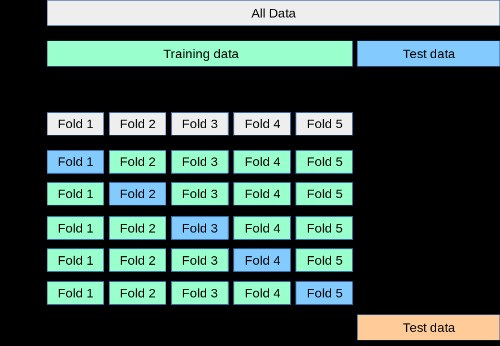

<b>From the sklearn documentation:</b>

> When evaluating the resulting model it is important to do it on held-out samples that were not seen during the grid search process: it is recommended to split the data into a development set (to be fed to the GridSearchCV instance) and an evaluation set to compute performance metrics.

### Cross Validation Scoring

We can use cross validation scoring on its own in place of normal scoring very easily to get a cross-validated version of the training scores, just replace the score function with cross_val_score. The result becomes an array of all the scores. 

A K value of 5 to 10 is pretty typical. 

In [22]:
#Cross validation scoring
crossV = tree.DecisionTreeClassifier()
scores = skms.cross_val_score(crossV, x, y, cv=5)
print(scores)
print(np.mean(scores))

[0.9122807  0.90350877 0.9122807  0.94736842 0.89380531]
0.9138487812451483


#### Exercise - Make Your Own Grid

Try to make a similar gridsearch with some differnent hyperparamaters. Look on the documentation page in sklearn and try a few options. 

In [25]:
#EXERCISE
#Create a dictionary of HP names and lists of potential values. 
#The grid search will try all of these options. 
tree_paraX = {'min_impurity_decrease':[.01,.1,1,10,100],
            "max_features":[5,9,15,"sqrt","log2"]
            }

clfX = skms.GridSearchCV(estimator = tree.DecisionTreeClassifier(), param_grid=tree_paraX, cv=10) #See below for the CV argument
clfX.fit(x_train, y_train)
print(clfX.score(x_test, y_test))
clfX.best_estimator_

0.9440559440559441


DecisionTreeClassifier(max_features=15, min_impurity_decrease=0.01)

### Grid Search and Cross Validation

One note to pay attention to as we start using these tools is that they can easily cause the amount of processing time needed to explode, since each trial is effectively a full end-to-end training process. Taking care to limit the number of options in a grid search, capping the number of cross validation trials, and performing initial work with a sample of the full data can all help prevent the time from running away. There are no strict rules on "how much stuff to try", if things take forever to run, start dialing some stuff back. 

## Ensamble Models - Random Forest

One common improvement made when using trees is to use several of them, or make a forest instead of a tree. More generally, this is our first look at an ensamble model - combining two or more predictive models to make a final prediction. 

The most simple way to create an ensamble is to use a Random Forest, which generates several trees that make predictions in parallel, then those predictions are combined (for a classification, majority wins) to make the final prediction. The magic behind this is that we are creating several uncorrelated predictions - each tree is generated from a random subset of the data. 

Random forests employ an ensamble method called Bagging, meaning that we run a bunch of models parallel to each other and get the result by combining the individual results; i.e. all the models are in a bag, and we pull out their combined answer. Another ensamble method is called boosting - using the results of one model's predictions to improve another's; we will look at boosting later on. 

Random forests will generally deliver more accuracy and less overfitting than a singular tree. More specifically it will tend to reduce the varaince in the predictions, as overfitting tends to 'cancel out' (sklearn's words) when many trees are created independently.

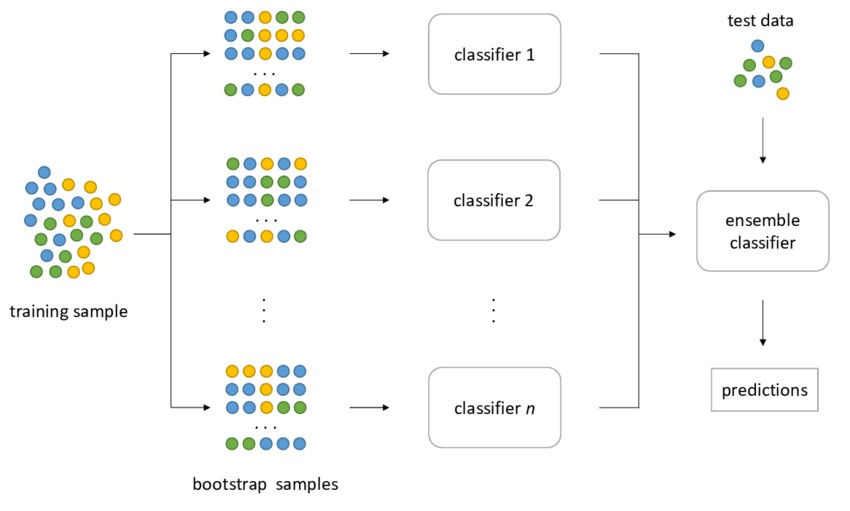

Using a Ramdom Forest is pretty easy, we can try one with a grid search, and up the number of HPs that we are tuning. Check the documentation page for a look at the paramaters that we could use: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

<b>Note:</b> the n_jobs argument is optional, that tells the system to create that number of threads, and those threads will be run in parallel on different cores of the computer. Modern CPUs have a bunch of cores 4-16 or more, so there's potential for some speedup there. My work Macbook I made this on has 4 (which I think can each double thread, to 8). If you get a weird error, just remove this. This isn't really a need to know, but it may speed some stuff up here and there. If someone were doing this on a powerful server you might have 64 cores, so you'd set that number to be high to ensure that calculations went in parallel on each one. 

### Bootstrapping

One key step that we have when using a random forest is bootstrapping, or making the datasets that each of those models in the ensable use. Bootstrapping generates random sets of data for each model by selecting data from the full training set. Each dataset is the same size as the original data, but it contains items that were selected randomly, with replacement. I.e. if our dataset is 100 items, to create each dataset while bootstrapping we would randomly pick an item from the full data, put that value in the boostrap set, leave the original in the full dataset (the original data stays at 100 items), and repeat that 100 times. The end result are a bunch of datasets that are very similar to the original, but slightly, and randomly, different. 

This bootstrapping step generates datasets that help the models be more resistant to overfitting, in simple terms it is harder for a model to overfit if the data it is being fit to is different in each of many (in the case of a forest, often 100) models. While one tree model might be able to overfit to its training data, there are very low odds of all 100 models getting a dataset that allows the same overfitting to happen, so the overfit models will be "overruled" when the final vote happens. 

### Feature Sampling

Ensables can also apply the same bootstrapping idea to the feature set - rather than use all the features to train the models, take some randomized subset for each model. This is kind of an odd concept, as we are purposefully removing data, but it can be helpful, mainly in combatting overfitting. We'll examine this idea a bit more when looking at neural networks and their ability to use a "dropout" to remove individual features from the training data at random.  

### Be Weak to be Strong

Ensable models bring up a concept that we will focus on in more depth when we look at boosting ensables and neural networks later on, the idea of weak and strong learners. The differentiation between weak and strong predictive models are (this is in the context of classifcation models):
<ul>
<li> <b>Strong Learners:</b>
    <ul>
    <li> Perform much better than random guessing. 
    <li> Take "more effort" to train and run. 
    <li> Most of the models we look at will fall into this category - logistic regression, SVM, etc...
    </ul>
<li> <b>Weak Learners:</b>
    <ul>
    <li> Perform slightly better than random guessing. 
    <li> Take little time/effort to train or use. 
    <li> "Small" versions of models such as 1 layer trees. 
    </ul>
</ul>

This distinction seems kind of odd at first glance, as there doesn't really seem to be much of a reason to ever use or care about a weak learner - why do we want something that does worse? Ensable models seek to overcome this by assembing multiple weak (or weaker) models together, taking advantage of the speed and non-overfitting of weak models to generate results that are (ideally) better than a standard strong model. The ensables we will look at now like a random forest normally combine a bunch of slightly "weaker" (usually not 1 layer, but normally not a massively large tree) models together to create a better model. When we look at boosted (another ensable technique) ensables, we'll spend more time on this. 

In [ ]:
rf_para = {'min_samples_split':[3,4,5,6,7],
            'max_depth':[3,4,5,6,7,8],
            'n_estimators':[20,50,80],
            'criterion':["gini","entropy"],
            'max_samples':[.4, .5, .6, .7]}

#clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_para, cv=10)
# If you get some weird error, uncomment above, and comment the line below. See the note above for more. 
 
clf = skms.GridSearchCV(estimator=ensemble.RandomForestClassifier(), param_grid=rf_para, cv=10, n_jobs=4) 
clf.fit(x_train, y_train.ravel())
clf.best_estimator_

### Pipeline with GridSearchCV

We can also use this with a pipeline, the main changes are:
<ul>
<li>The estimator in the grid search becomes the pipeline.
<li>The paramaters in the param_grid need to be named "stepName__variable". See the example below.
</ul>

This can be extened pretty much indefinitely, we can have a pipelines as part of a column transformer, as part of another pipeline, etc... all plugged into the Grid Search. As long as calling .fit() on whatever we put into the grid search is valid. 

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = preprocessing.StandardScaler()
estimator = ensemble.RandomForestClassifier(n_jobs=-1)
pipe = pipeline.Pipeline(steps=[("scaler", scaler), ("forrest", estimator)])

params = {'forrest__max_depth':[5,6,7,8,9]}
 
clf = skms.GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1) 
clf.fit(x_train, y_train.ravel())
best = clf.best_estimator_
print(best.score(x_test, y_test))
print(best)

0.972027972027972
Pipeline(steps=[('scaler', StandardScaler()),
                ('forrest', RandomForestClassifier(max_depth=7, n_jobs=-1))])


#### Non-Tree Bagging

In general the BaggingClassifier in sklearn can apply the same concept to other classification methods, and the BaggingRegressor can do the same for regression. 

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(base_estimator=LogisticRegression(max_iter=10000),n_estimators=10, random_state=0).fit(X_train, y_train.ravel())
bag.score(X_test, y_test)

0.951048951048951

## Exercise

<b>Predict the Target.</b>

In [10]:
df_ = sklearn.datasets.load_iris()
df_.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [11]:
#Model
from sklearn.preprocessing import MinMaxScaler

y_ = np.array(df_["target"]).reshape(-1,1)
X_ = np.array(df_.drop(columns={"target"}))
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_)

scaler_ = MinMaxScaler()
estimator_ = RandomForestClassifier(n_jobs=-1)
pipe_ = Pipeline(steps=[("scaler", scaler_), ("forrest", estimator_)])

params_ = {'forrest__max_depth':[5,6,7,8,9], "forrest__n_estimators":[75,100,125]}
 
clf_ = GridSearchCV(pipe_, param_grid=params_, cv=5, n_jobs=-1) 
clf_.fit(X_train_, y_train_.ravel())
best_ = clf_.best_estimator_
print(best_.score(X_test_, y_test_))
print(best_)

0.8947368421052632
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('forrest', RandomForestClassifier(max_depth=7, n_jobs=-1))])
